## FINAL MODEL 

Polaczenie LightBgm z RandomForest za pomoca soft VoteClassifiera

In [14]:
from ColumnTransformers import * 
from AdvModels import *
import shap
import matplotlib.pyplot as plt

Funkcje przygotowujące każdy ze składowych modeli z osobna, ostateczny model (VoteClassifier) i rysujące wykres z SHAP
Przy użyciu selektorów cech każdy z tych modeli pracuje na 18 najbardziej znaczących cechach

In [ ]:
def LGBMClassifierPipeline(): 
    model=LGBMClassifier(
        colsample_bytree=0.8,
        is_unbalance=True,
        learning_rate=0.01,
        max_depth=2,
        min_split_gain=0.1,
        n_estimators=600,
        reg_lambda=1,
        subsample=1,
        verbosity=-1,
        random_state=42
    )
    result=PipelineModel(model,n=18)
    return result

def RandomForestClassifierPipeline(): 
    model=RandomForestClassifier(
        n_estimators=200,
        min_samples_split=5,
        min_samples_leaf=10,
        max_features=0.5,
        max_depth=8,
        class_weight="balanced",
        random_state=42
    ) 
    result=PipelineModel(model,n=18)
    return result
        

def create_voting_classifier():
    randomforest_pipeline = RandomForestClassifierPipeline()
    lgbm_pipeline = LGBMClassifierPipeline() 
    print(type(lgbm_pipeline))
    voting_ensemble = VotingClassifier(
        estimators=[
            ('randomforest', randomforest_pipeline),
            ('lgbm',     lgbm_pipeline)
        ],
        voting='soft'
    )
    return voting_ensemble

# def lgbmImportanceGetter(X_train,y_train): 
#     pipeline=LGBMClassifierPipeline() 
#     pipeline.fit(X_train,y_train)
#     feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

#     selector = pipeline.named_steps["featureselection"]
#     support_mask = selector.support_
#     selected_features = feature_names[support_mask]

#     model = pipeline.named_steps["model"]
#     importances = model.feature_importances_  
#     feature_importance_df = pd.DataFrame({
#     "Feature": selected_features,
#     "Importance": importances
#     }).sort_values(by="Importance", ascending=False)
#     return feature_importance_df

# def lgbmShapGetter(X):
#     pipeline=LGBMClassifierPipeline() 
#     Xt = pipeline.named_steps["preprocessor"].transform(X)
#     selector = pipeline.named_steps["featureselection"]
#     Xt = selector.transform(Xt)              
#     feature_names = (
#         pipeline.named_steps["preprocessor"]
#         .get_feature_names_out()[selector.support_]
#     )
    
#     lgb_booster = pipeline.named_steps["model"].booster_
#     explainer = shap.TreeExplainer(lgb_booster)

#     shap_values = explainer.shap_values(Xt)        
#     return shap_values, feature_names

def plotShap(model,X_train,y_train):

    model.fit(X_train,y_train)
 
    prep_and_rfe = model[:-1]                
    lgbm         = model.named_steps["model"] 
    X_train_t = prep_and_rfe.transform(X_train)     

    feature_names = prep_and_rfe.get_feature_names_out()


    explainer   = shap.TreeExplainer(lgbm)
    shap_values = explainer(X_train_t)
    shap.summary_plot(
    shap_values,
    features      = X_train_t,
    feature_names = feature_names,
    plot_size     = (20, 14)       
    )
    plt.show() 


Funkcja testująca pojedynczy model

In [16]:
def TestingModel(Model,X_train,X_test,y_train,y_test,threshold): 

    Model.fit(X_train,y_train) 
    y_scores=Model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    aucPlot(fpr, tpr,roc_auc)

    y_pred = (np.array(y_scores) > threshold).astype(int)
    PredictionQualityInfo(y_pred,y_test)
    print(f"AUC: {roc_auc}, Recall: {recall_score(y_test,y_pred)}")
    return Model

Stworzenie finalnego modelu i ewaluacja jego pracy

In [17]:
def FinalModel(X_train,X_test,y_train,y_test,threshold=0.5): 
    finalModel=create_voting_classifier()
    set_config(display='diagram')
    display(finalModel)
    finalModel.fit(X_train,y_train)
    y_scores=finalModel.predict_proba(X_test)[:, 1]  
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    aucPlot(fpr, tpr,roc_auc)
    y_pred = (np.array(y_scores) > threshold).astype(int)
    PredictionQualityInfo(y_pred,y_test)
    print(f"AUC: {roc_auc}")
    return finalModel

In [18]:
def getTrainingData():
    df =pd.read_csv("../data/TrainData.csv")
    X = df.drop(columns=["Is.Fraudulent"]).copy()
    y = df["Is.Fraudulent"].copy()
    return X,y
def getTestData():
    df=pd.read_csv("../data/TestData.csv")
    X = df.drop(columns=["Is.Fraudulent"]).copy()
    y = df["Is.Fraudulent"].copy()
    return X,y
    
def getValidationData():
    df=pd.read_csv("../data/ValidationData.csv")
    X = df.drop(columns=["Is.Fraudulent"]).copy()
    y = df["Is.Fraudulent"].copy()
    return X,y

In [69]:
X_train,y_train=getTrainingData()
X_test,y_test=getTestData()

## Performance oddzielnych modeli

In [20]:
lgbm = LGBMClassifierPipeline()
randomforest = RandomForestClassifierPipeline()

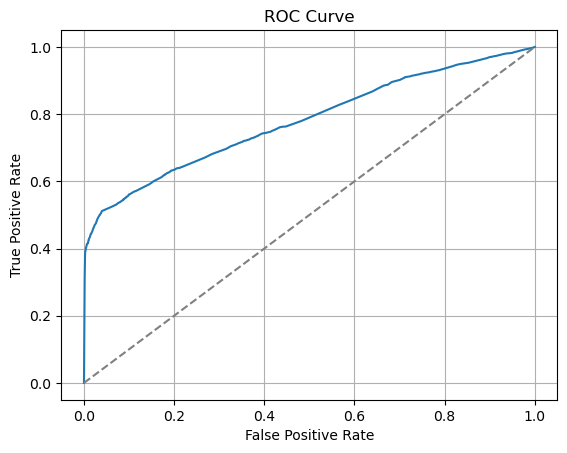

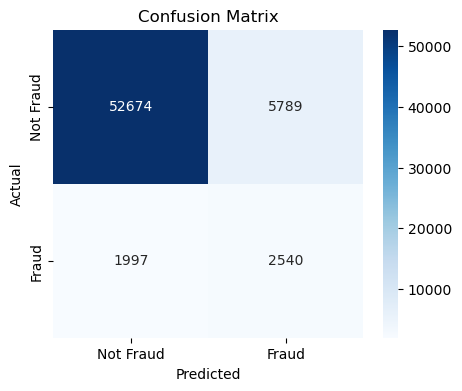

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93     58463
           1       0.30      0.56      0.39      4537

    accuracy                           0.88     63000
   macro avg       0.63      0.73      0.66     63000
weighted avg       0.92      0.88      0.89     63000

AUC: 0.7787156569012181, Recall: 0.5598413048269781


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('time_features',
                                                  TimeTransformer(),
                                                  ['Transaction.Date',
                                                   'Transaction.Hour']),
                                                 ('high_amount',
                                                  HighAmountTransformer(),
                                                  ['Transaction.Amount']),
                                                 ('numerical', StandardScaler(),
                                                  ['Transaction.Amount',
                                                   'Customer.Age',
                                                   'Account.Age.Days',
                                                   'Quantity']),
                                                 ('age', AgeTransfomer(),
                                                  ['Customer.Age']),
                                                 ('sex',...
                                                   'Device.Used',
                                                   'source'])])),
                ('featureselection',
                 RFE(estimator=LogisticRegression(C=0.1,
                                                  class_weight='balanced',
                                                  penalty='l1', random_state=42,
                                                  solver='liblinear'),
                     n_features_to_select=18)),
                ('model',
                 LGBMClassifier(colsample_bytree=0.8, is_unbalance=True,
                                learning_rate=0.01, max_depth=2,
                                min_split_gain=0.1, n_estimators=600,
                                reg_lambda=1, subsample=1, verbosity=-1))])

In [8]:
TestingModel(lgbm,X_train,X_test,y_train,y_test,threshold=0.5)

Dla LGBM największe znaczenie mają:
* długość istnienia konta,
* informacja, czy transakcja została dokonana w pierwszych 12 dniach miesiąca,
* wysokość kwoty transakcji

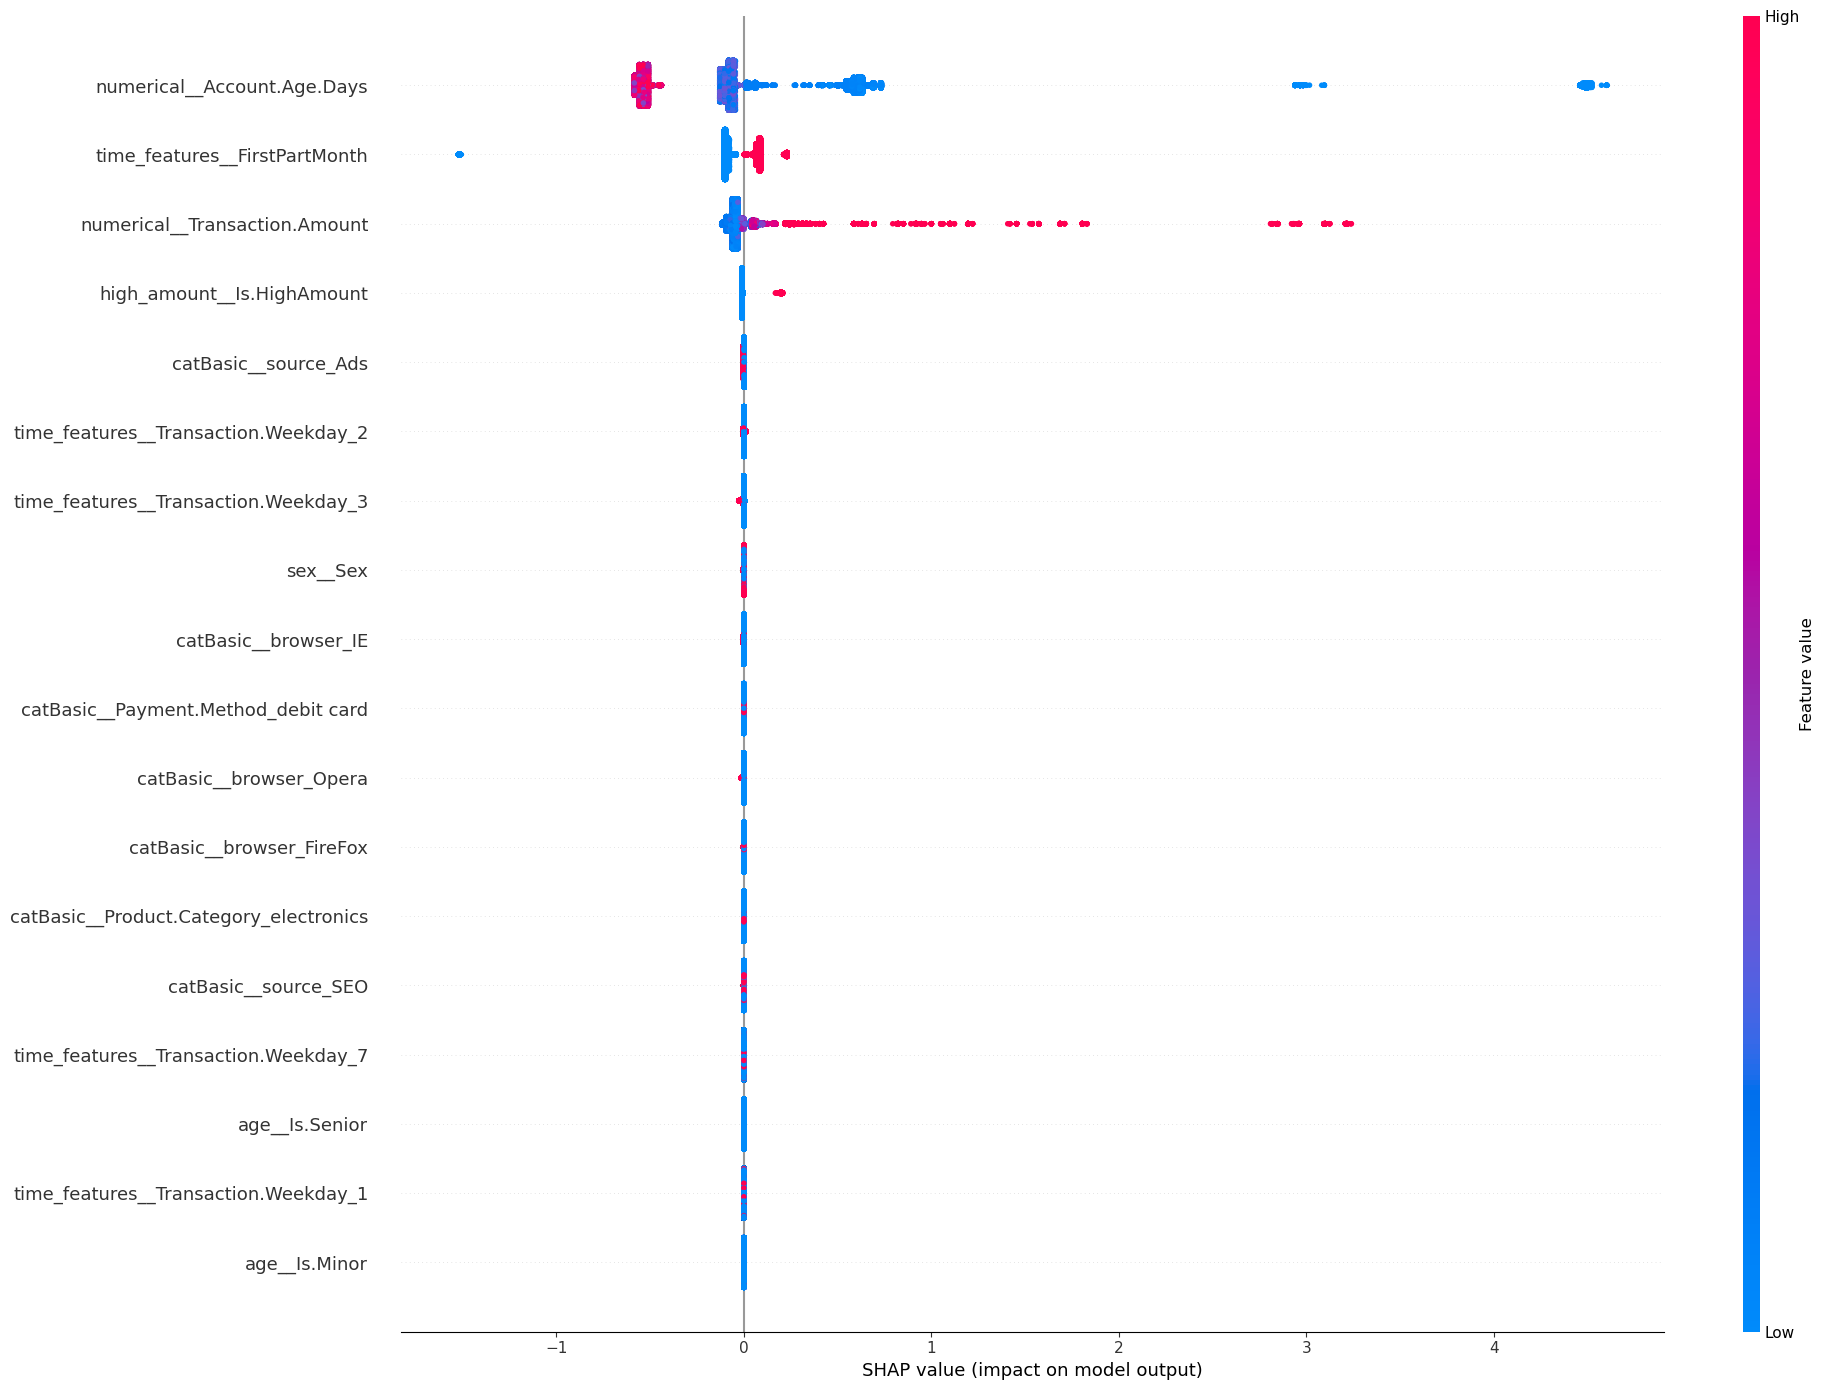

In [9]:
plotShap(lgbm,X_train,y_train)

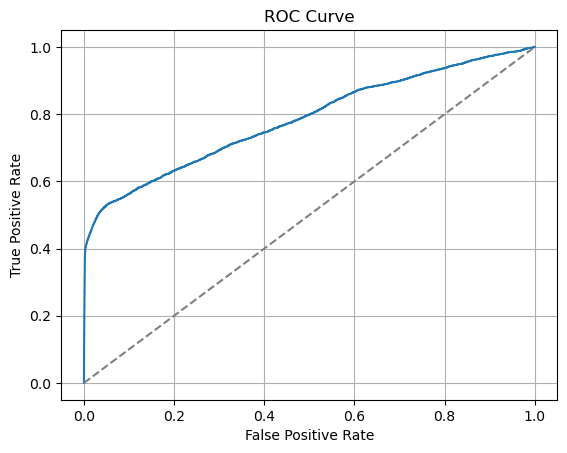

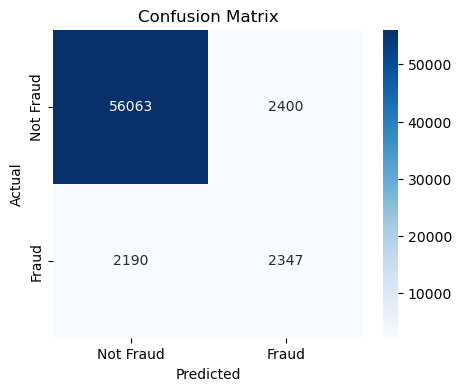

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96     58463
           1       0.49      0.52      0.51      4537

    accuracy                           0.93     63000
   macro avg       0.73      0.74      0.73     63000
weighted avg       0.93      0.93      0.93     63000

AUC: 0.7836116719612549, Recall: 0.5173021820586291


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('time_features',
                                                  TimeTransformer(),
                                                  ['Transaction.Date',
                                                   'Transaction.Hour']),
                                                 ('high_amount',
                                                  HighAmountTransformer(),
                                                  ['Transaction.Amount']),
                                                 ('numerical', StandardScaler(),
                                                  ['Transaction.Amount',
                                                   'Customer.Age',
                                                   'Account.Age.Days',
                                                   'Quantity']),
                                                 ('age', AgeTransfomer(),
                                                  ['Customer.Age']),
                                                 ('sex',...
                                                   'Product.Category',
                                                   'Device.Used',
                                                   'source'])])),
                ('featureselection',
                 RFE(estimator=LogisticRegression(C=0.1,
                                                  class_weight='balanced',
                                                  penalty='l1', random_state=42,
                                                  solver='liblinear'),
                     n_features_to_select=18)),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=8,
                                        max_features=0.5, min_samples_leaf=10,
                                        min_samples_split=5, n_estimators=200,
                                        random_state=42))])

In [10]:
TestingModel(randomforest,X_train,X_test,y_train,y_test,threshold=0.5)

(Z jakiegoś powodu shap w tym przypadku nie działa)
Dla RandomForest, tak jak dla LGBM, największe znaczenie mają:
* długość istnienia konta,
* informacja, czy transakcja została dokonana w pierwszych 12 dniach miesiąca,
* wysokość kwoty transakcji

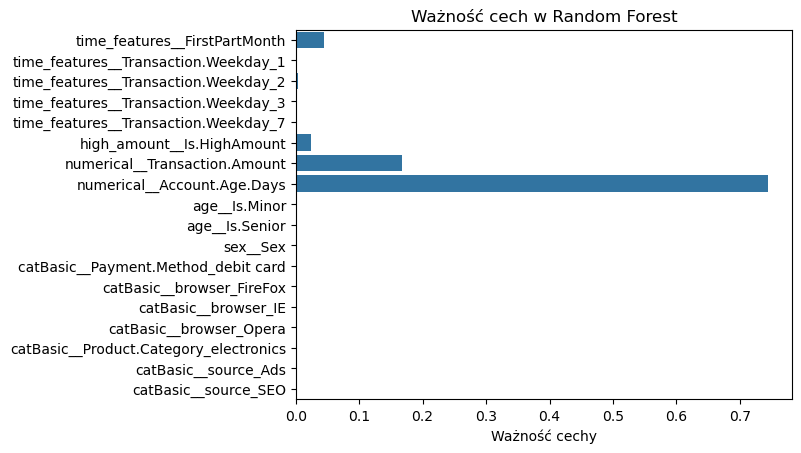

In [ ]:
randomforest.fit(X_train,y_train)
importances = randomforest.named_steps["model"].feature_importances_

prep_and_rfe = randomforest[:-1]                
feature_names = prep_and_rfe.get_feature_names_out()

import matplotlib.pyplot as plt
sns.barplot(y = feature_names, x = importances, orient = 'h')
plt.xlabel("Ważność cechy")
plt.title("Ważność cech w Random Forest")
plt.show()

## Finalny model

<class 'sklearn.pipeline.Pipeline'>


VotingClassifier(estimators=[('randomforest',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('time_features',
                                                                                TimeTransformer(),
                                                                                ['Transaction.Date',
                                                                                 'Transaction.Hour']),
                                                                               ('high_amount',
                                                                                HighAmountTransformer(),
                                                                                ['Transaction.Amount']),
                                                                               ('numerical',
                                                                                StandardScaler(),
                                                                                ['Transaction.Amount',
                                                                                 'Customer.Age',
                                                                                 'Account.Age.Days',
                                                                                 'Quantity']),
                                                                               ('a...
                                              ('featureselection',
                                               RFE(estimator=LogisticRegression(C=0.1,
                                                                                class_weight='balanced',
                                                                                penalty='l1',
                                                                                random_state=42,
                                                                                solver='liblinear'),
                                                   n_features_to_select=18)),
                                              ('model',
                                               LGBMClassifier(colsample_bytree=0.8,
                                                              is_unbalance=True,
                                                              learning_rate=0.01,
                                                              max_depth=2,
                                                              min_split_gain=0.1,
                                                              n_estimators=600,
                                                              random_state=42,
                                                              reg_lambda=1,
                                                              subsample=1,
                                                              verbosity=-1))]))],
                 voting='soft')

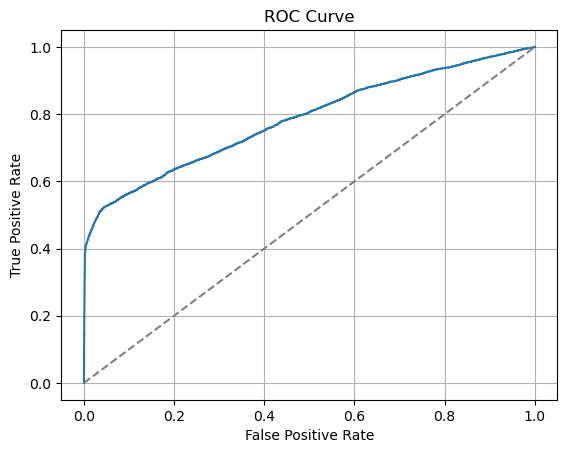

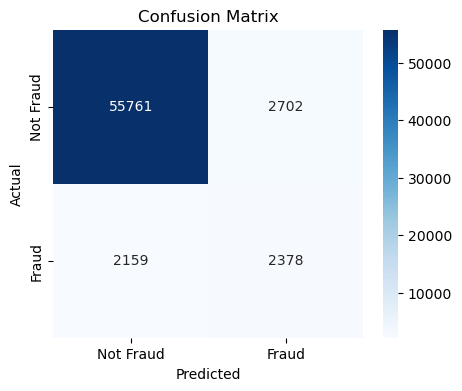

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96     58463
           1       0.47      0.52      0.49      4537

    accuracy                           0.92     63000
   macro avg       0.72      0.74      0.73     63000
weighted avg       0.93      0.92      0.92     63000

AUC: 0.7846734121196057


In [7]:
FinalModel=FinalModel(X_train,X_test,y_train,y_test)

## Test walidacji

In [ ]:
X_train,y_train=getTestData()
X_test,y_test=getTrainingData()
X_Merged = pd.concat([X_train, X_test]).reset_index(drop=True)
Y_Merged = pd.concat([y_train, y_test]).reset_index(drop=True)

In [ ]:
X_Validation,Y_Validation=getValidationData()
FinalModel(X_Merged,X_Validation,Y_Merged,Y_Validation,threshold=0.5)